# Forecasting Hurricane Tracks using Satellite Data Accessed from AWS

When I originally took a crack at forecasting hurricanes with Tensorflow back in 2019, I used Reanalysis data I had to download via ftp and satelitte imagery I webscraped from NASA. It worked well enough, except the reanlysis II data had one major flaw; it was not a perfect mirror for what could be acquired live via NOAA's various other products. Since that time, there's been a major effort by NOAA and other government agencies via the [NOAA Big Data Program](https://www.noaa.gov/organization/information-technology/big-data-program) to move many of both NOAA and NASA's data products to the cloud, both on Amazon AWS and Google Cloud. Many of these datasets span back 3-4 years, and include hourly observations, instead of the 6 hour increments from the reanalysis datasets previously used. Most importantly, however, new observations are added live, in the same format and in the same location, so using a model developed with these datasets could be adapted to live forecasting with minimal effort.

The downside here is that the historic data would ideally cover a longer time period. Our historic track data is every 3 hours, so even if we augment this via interpolation and assume that our hourly interpolated data is accurate enough to use for training, we're still limited in that there were a finite number of storms during this period and there may be several regions of the world that commonly see storms pass through which didn't see one during this period, and therefore our model may not properly learn storm behavoirs in those regions.

Ultimately, down the road we'll probably  want to create a composite training set that includes the previous Reanlysis II data as well, but I wanted to first present a comprehensive methodology for accessing these new datasets, and using them to train Tensorflow models. Adding in the older data for a longer training period is likely to be the next step, and will likely require that we shift which AWS / GCP datasets we draw from to match like with like, but the code to access them should work the same. 

To begin, I'll start with the Geospatial Satellite data from AWS (GOES16 and 17). The Google data requires a few extra steps to use properly as you need to sign up for a Google Earth Engine account. Google Earth Engine offers a lot of nice features, from the ability to export data into tf.data datasets to being able to use it to directly train hosted models directly on GCP and create high resolution maps including data from other sources fairly easily, but the drawback is that most of the examples are in javascript and assume users will use the javascript browser IDE to pull data. That means some going back and forth from python to js. So, I'm going to start with the AWS data for now, as it allows me to keep everything in a single Jupyter notebook that doesn't rely on premium GCP services to run and is fairly easy follow.

Anyway, Let's begin!

As a starting point, check out this notebook: [Visualize GOES-16 Data from S3](https://github.com/HamedAlemo/visualize-goes16/blob/master/visualize_GOES16_from_AWS.ipynb)

I'll be using some of the code here to get things rolling.

In [1]:
from tensorflow.keras.layers import Input, Dense, concatenate, Dropout,BatchNormalization,DenseFeatures,GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential,load_model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow import feature_column as fc
from tensorflow.compat.v1.losses import mean_pairwise_squared_error

# from math import floor
import tensorflow as tf
# from get_data_v4_generalized import open_pkl_multi
from tensorflow.keras import backend as K
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.callbacks import Callback,EarlyStopping,CSVLogger,ReduceLROnPlateau
# os.environ['CUDA_VISIBLE_DEVICES'] = "-1"

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)


In [2]:
import xarray as xr
import requests
import netCDF4
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime,timedelta
from tqdm import tqdm
import gc
import os
from IPython.display import Image
import cv2
os.environ['PROJ_LIB'] = r'c:\Users\kylea\AppData\Local\conda\conda\envs\hurricanes\Library\share'

from mpl_toolkits.basemap import Basemap
from pyproj import Proj
import numpy as np
from math import pi



# See Previous Notebook for Preprocessing
Check out the processing steps in the previous notebook. We'll just be loading our train, test, and validation dataframes from what was done there and picking up with our revised model and evaluation steps.

In [3]:
regular_hours=[0,3,6,9,12,15,18,21]
filtered=pd.read_pickle('filtered.pkl')
train_df=pd.read_pickle('train_df.pkl')
val_df=pd.read_pickle('val_df.pkl')
test_df=pd.read_pickle('test_df.pkl')

# Create Tensorflow Dataset
Tensorflow has made some major changes in recent years, especially with V2.0. TF.Data is among the biggest. Instead of training with basic numpy arrays as inputs, Tensorflow would now like you to use its own data format. You still can use numpy if your dataset fits in memory, or even use a generator to create samples if it does not, but you're only using a single local machine. However, if you want to train with tf.estimator, which lets you easily train across a cluster in the cloud or across multiple gpus on a single machine, you need to use tf.data. Further, using tf.data allows us to use Tensorflow's 'feature columns' which, as previously discussed, we'll be using here. They allow you to do a fair amount of both preprocessing, like normalization, without needing to use SK-Learn, but more relevant to this project, they enable us to created bucketized features and feature crosses with just a few lines of code.

That all said, the Tensorflow Dataset can be a bit tricky to setup, especially with a multi-input model like we'll be using here. Further, the examples given in the tensorflow documentation assume that our dataset consists of all files within a given directory. But we have plenty of images we don't wish to use, and we also need to ensure consistency between the images we load, and the associated other data we wish to train with. So, using tf.keras.preprocessing.image_dataset_from_directory is out of the question for us. We'll need to instead write our own preprocessing functions, and then map everything to a single dataset.

Much of this code follows the example from the Tensorflow documentation on [using tf.data for finer control](https://www.tensorflow.org/tutorials/load_data/images#using_tfdata_for_finer_control).

In [4]:
img_height=img_width=224
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_png(img, channels=3)
  # resize the image to the desired size
    img= tf.image.resize(img, [img_height, img_width])
    return preprocess_input(img)

In [5]:
def process_path(file_path,return_dict=True):
#     label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    if return_dict:
        return {'image':img}
    else:
        return img

In [6]:
def load_all_images(paths):
    imgs=[]
    for path in paths:
        imgs.append(process_path(path,return_dict=False))
    return imgs

In [7]:
img_paths=r"./storm_centered/"+test_df['filename']

images=load_all_images(img_paths)

In [8]:
print(images[0].shape)

(224, 224, 3)


## Two Versions of "create_dataset" function
If we scale this up, we're going to want a dataset that can pull batches off of some sort of storage medium, either locally or on the cloud. However, this entire dataset of both images and auxillary numerical data should easily fit in memory on my system, which has 64GB of RAM. Caching a dataset to memory is significantly faster and less CPU intense, as it doesn't require multiple threads to work in tandum preparing the next batch while one is being used. Normally, we'd just use the tf.data dataset's "cache" method to load it to memory during the first epoch of training, but it turns out that in the case of tf.data, it's also much easier to format it correctly if we load all the image data within the create_dataset function, since we can add both our numerical and image data to a single Python dictionary, and then create a dataset from tensor slices in a single call. Zipping image data to auxillary data via the other approach is tricky, as the image data gets nested within the auxillary dataset, and I'm not certain yet that the model's feature columns will work properly with it via a simple reference to the "image" feature.

For now, I'm going to use the approach below in the "create_dataset" function which loads all image data at time of creation and caches the dataset to memory.

I'm also including an as of yet untested version called "create_dataset_not_cached" which loads image data on the fly, but might not work properly with the model we build later, since I'm not sure if we can simply link the image features to our model.

In [9]:
def create_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    img_paths=r"./storm_centered/"+dataframe.pop('filename')
#     all_images=load_all_images(img_paths)
    labels = dataframe[['delta_lat_48hrs', 'delta_lon_48hrs']].copy()
    dataframe.drop(columns=['SID','ISO_TIME','year','day_of_year', 'delta_lat_48hrs','delta_lon_48hrs'],inplace=True)
    inputs=dict(dataframe)
    inputs['image']=load_all_images(img_paths)
    ds=tf.data.Dataset.from_tensor_slices((inputs,labels.values))
#     dataset = tf.data.Dataset.from_tensor_slices(({"input_1": sent1, "input_2": sent2}, labels))


#     labels_ds=tf.data.Dataset.from_tensor_slices(labels.values)
#     ds = tf.data.Dataset.from_tensor_slices((all_input_ds, dict(labels)))
#     ds = tf.data.Dataset.zip((all_input_ds, labels_ds))
    ds=ds.cache()
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    
    return ds

In [10]:
def create_dataset_not_cached(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    filenames=r"./storm_centered/"+dataframe.pop('filename')
    files_ds=tf.data.Dataset.from_tensor_slices(filenames)
    images = files_ds.map(process_path, num_parallel_calls=4)
    images.name='image'
    labels = dataframe[['delta_lat_48hrs', 'delta_lon_48hrs']].copy()
    dataframe.drop(columns=['SID','ISO_TIME','year','day_of_year', 'delta_lat_48hrs','delta_lon_48hrs'],inplace=True)
    aux_inputs=tf.data.Dataset.from_tensor_slices(dict(dataframe))
    all_input_ds = tf.data.Dataset.zip((aux_inputs, images))
    labels_ds=tf.data.Dataset.from_tensor_slices(labels.values)
    ds = tf.data.Dataset.zip((all_input_ds, labels_ds))

    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)

    return ds

In [11]:
batch_size=32

#we want to load our data to system memory, not our GPU's memory. That will be reserved for our model.
with tf.device('/CPU:0'):
    train_ds=create_dataset(train_df,batch_size=batch_size)
    val_ds = create_dataset(val_df,batch_size=batch_size,shuffle=False)
    test_ds=create_dataset(test_df,batch_size=batch_size,shuffle=False)

In [12]:
list(train_ds.take(1))

[({'LAT': <tf.Tensor: shape=(32,), dtype=float32, numpy=
   array([16.865 , 20.7   , 26.0341, 17.5425, 16.3074, 10.25  , 14.2   ,
          11.4   , 13.4925, 29.2925, 14.7   , 10.0958, 15.3   , 32.4224,
          11.2   , 28.    , 19.1   , 15.1925, 13.0667, 19.2   , 11.5   ,
          17.1   , 12.6499, 14.6299, 12.3872, 19.3   , 12.3497, 16.0724,
          10.7   , 28.5658, 12.2   , 15.57  ], dtype=float32)>,
   'LON': <tf.Tensor: shape=(32,), dtype=float32, numpy=
   array([-113.715 , -118.7   ,  -90.6119, -115.808 , -112.693 ,  -91.5425,
          -105.5   ,  -81.2   ,  -83.2925,  -68.7575,  -87.5   ,  -82.61  ,
          -122.5   ,  -74.4225, -110.    ,  -56.3   ,  -41.1   , -141.438 ,
          -122.233 , -108.7   ,  -50.3   ,  -87.1   ,  -34.25  , -121.385 ,
          -111.258 , -110.4   ,  -51.8425, -135.828 , -130.    ,  -89.8756,
           -62.5   , -119.507 ], dtype=float32)>,
   'STORM_SPEED': <tf.Tensor: shape=(32,), dtype=float32, numpy=
   array([ 6., 11.,  7.,  8.,  8., 

# Create Feature Columns
Creating a tf.data dataset like we did above is clearly more complicated than what most of us Tensorflow Developers have historically done when training with simple numpy data. But here's the payoff; we'll be doing some really fancy data engineering right within our model using Tensorflow's new feature_column class, which will enable us to handle non-linearities and interaction between dependent features (like latitude and longitude) much better than we otherwise could, without heavy preprocessing. We can also do the more standard preprocessing steps, like normalization, much more easily and without the need to fit a SK-Learn scaler object separately.

## Bring in Data
In our current dataset, the only categorical is hour of day. Recall, we also use two engineered continuous numerical equiavalents for this as well, but the raw categorical may end up being useful.  We removed year and day_of_year in favor of our numerical equivalents, as those could lead to overfitting.

## Normalization
Reference: https://medium.com/ml-book/train-tf-keras-model-using-feature-coulmn-8de12e65ddec

In [13]:
def get_scal(feature):
    def minmax(x):
        mini = train_df[feature].min()
        maxi = train_df[feature].max()
        return (x - mini)/(maxi-mini)
    return(minmax)

In [14]:
numeric_names=['LAT', 'LON', 'STORM_SPEED', 'STORM_DIR',
       'sin_STORM_DIR', 'cos_STORM_DIR','sin_day_of_year', 
       'cos_day_of_year', 'sin_hour', 'cos_hour','size']

categorical_names=['hour']


deep_features=[]
for name in numeric_names:
    scal_input_fn = get_scal(name)
    deep_features.append(fc.numeric_column(name,normalizer_fn=scal_input_fn))

#we only have one of these... hour
wide_features=[fc.indicator_column(fc.categorical_column_with_vocabulary_list('hour',vocabulary_list=regular_hours))]

# image_features=fc.numeric_column('image',shape=(img_height,img_width,3))


# Feature Engineering with feature_columns
Reference: https://developers.googleblog.com/2017/11/introducing-tensorflow-feature-columns.html

### Position Encoding

In [15]:
num_coordinate_buckets=100 #this is a variable we'll want to experiement with eventually

latitude_buckets = list(np.linspace(filtered['LAT'].min(), filtered['LAT'].max(), num_coordinate_buckets))
longitude_buckets = list(np.linspace(filtered['LON'].min(), filtered['LON'].max(), num_coordinate_buckets))


latitude_fc = tf.feature_column.bucketized_column(deep_features[0],latitude_buckets)
longitude_fc = tf.feature_column.bucketized_column(deep_features[1],longitude_buckets)

# cross features for grid boxes locations.
crossed_loc = fc.crossed_column(
    [latitude_fc, longitude_fc],
    hash_bucket_size=num_coordinate_buckets * num_coordinate_buckets)
wide_features.append(fc.indicator_column(crossed_loc))
# wide_features=tf.feature_column.make_parse_example_spec(wide_features)

# add embedding layer output of this we can also feed into deep network
loc_embedding = fc.embedding_column(categorical_column=crossed_loc, dimension=8)
deep_features.append(loc_embedding)
# deep_features=tf.feature_column.make_parse_example_spec(deep_features)


### Bucketization of Other Variables

In [16]:
general_buckets=10
speed_buckets = list(np.linspace(filtered['STORM_SPEED'].min(), filtered['STORM_SPEED'].max(), general_buckets))
dir_buckets = list(np.linspace(filtered['STORM_DIR'].min(), filtered['STORM_DIR'].max(), general_buckets))
size_buckets = list(np.linspace(filtered['size'].min(), filtered['size'].max(), general_buckets))


speed_fc = tf.feature_column.bucketized_column(deep_features[2],speed_buckets)
dir_fc = tf.feature_column.bucketized_column(deep_features[3],dir_buckets)
size_fc = tf.feature_column.bucketized_column(deep_features[10],size_buckets)

wide_features.append(fc.indicator_column(speed_fc))
wide_features.append(fc.indicator_column(dir_fc))
wide_features.append(fc.indicator_column(size_fc))

# Build Deeper Model
We'll incorporate transfer learning here by importing MobileNetV2 into the image processing branch. Also, we'll add some batch normaliation and another dense layer after the concatenation to pull everything together a bit more cleanly.

In [17]:
INPUT_COLS = ['LAT', 'LON', 'STORM_SPEED', 'STORM_DIR','sin_STORM_DIR', 'cos_STORM_DIR',
       'sin_day_of_year', 'cos_day_of_year', 'sin_hour', 'cos_hour', 'size']

inputs = {colname : Input(name=colname, shape=(), dtype='float32')
          for colname in INPUT_COLS}
inputs['hour']= Input(name='hour', shape=(), dtype='int32')

inputs['image']=Input(name='image',shape=(img_height,img_width,3),dtype='float32')

In [18]:
inputs['hour']

<KerasTensor: shape=(None,) dtype=int32 (created by layer 'hour')>

In [19]:
def build_model(dnn_hidden_units=[64,32],out_dim=2):
    
    # Create the deep part of model
    deep = DenseFeatures(deep_features, name='deep_inputs')(inputs)
    for num_nodes in dnn_hidden_units:
        deep = Dense(num_nodes, activation='relu')(deep) 

    # Create the wide part of model
    wide = DenseFeatures(wide_features, name='wide_inputs')(inputs)

    image_net= MobileNetV2(weights='imagenet',input_shape=(img_height,img_width,3),include_top=False)(inputs['image'])
    image_net=GlobalAveragePooling2D()(image_net)
    image_net=Dense(128,activation='relu')(image_net)
    image_net=Dense(64,activation='relu')(image_net)
    image_net=Dense(32,activation='relu')(image_net)

    # Combine deep and wide parts of the model
    combined = concatenate(inputs=[deep, wide, image_net], name='combined')
    batch_norm_layer=BatchNormalization()(combined)
    final_wide_layer=Dense(32,activation='relu')(batch_norm_layer)

    dropout_layer=Dropout(0.3)(final_wide_layer)
    # Map the combined outputs into a single prediction value
    output = Dense(out_dim, activation=None, name='prediction')(dropout_layer)
    
    # Finalize the model
    model = Model(inputs=list(inputs.values()), outputs=output)

    # Compile the keras model
    model.compile(loss=mean_pairwise_squared_error, optimizer=Adamax(lr=1e-3,clipnorm=1.))
    
    return model

Note: dropout reduced from 0.5 to 0.3. Previous model did not show signed of overfitting.

In [20]:
model=build_model()

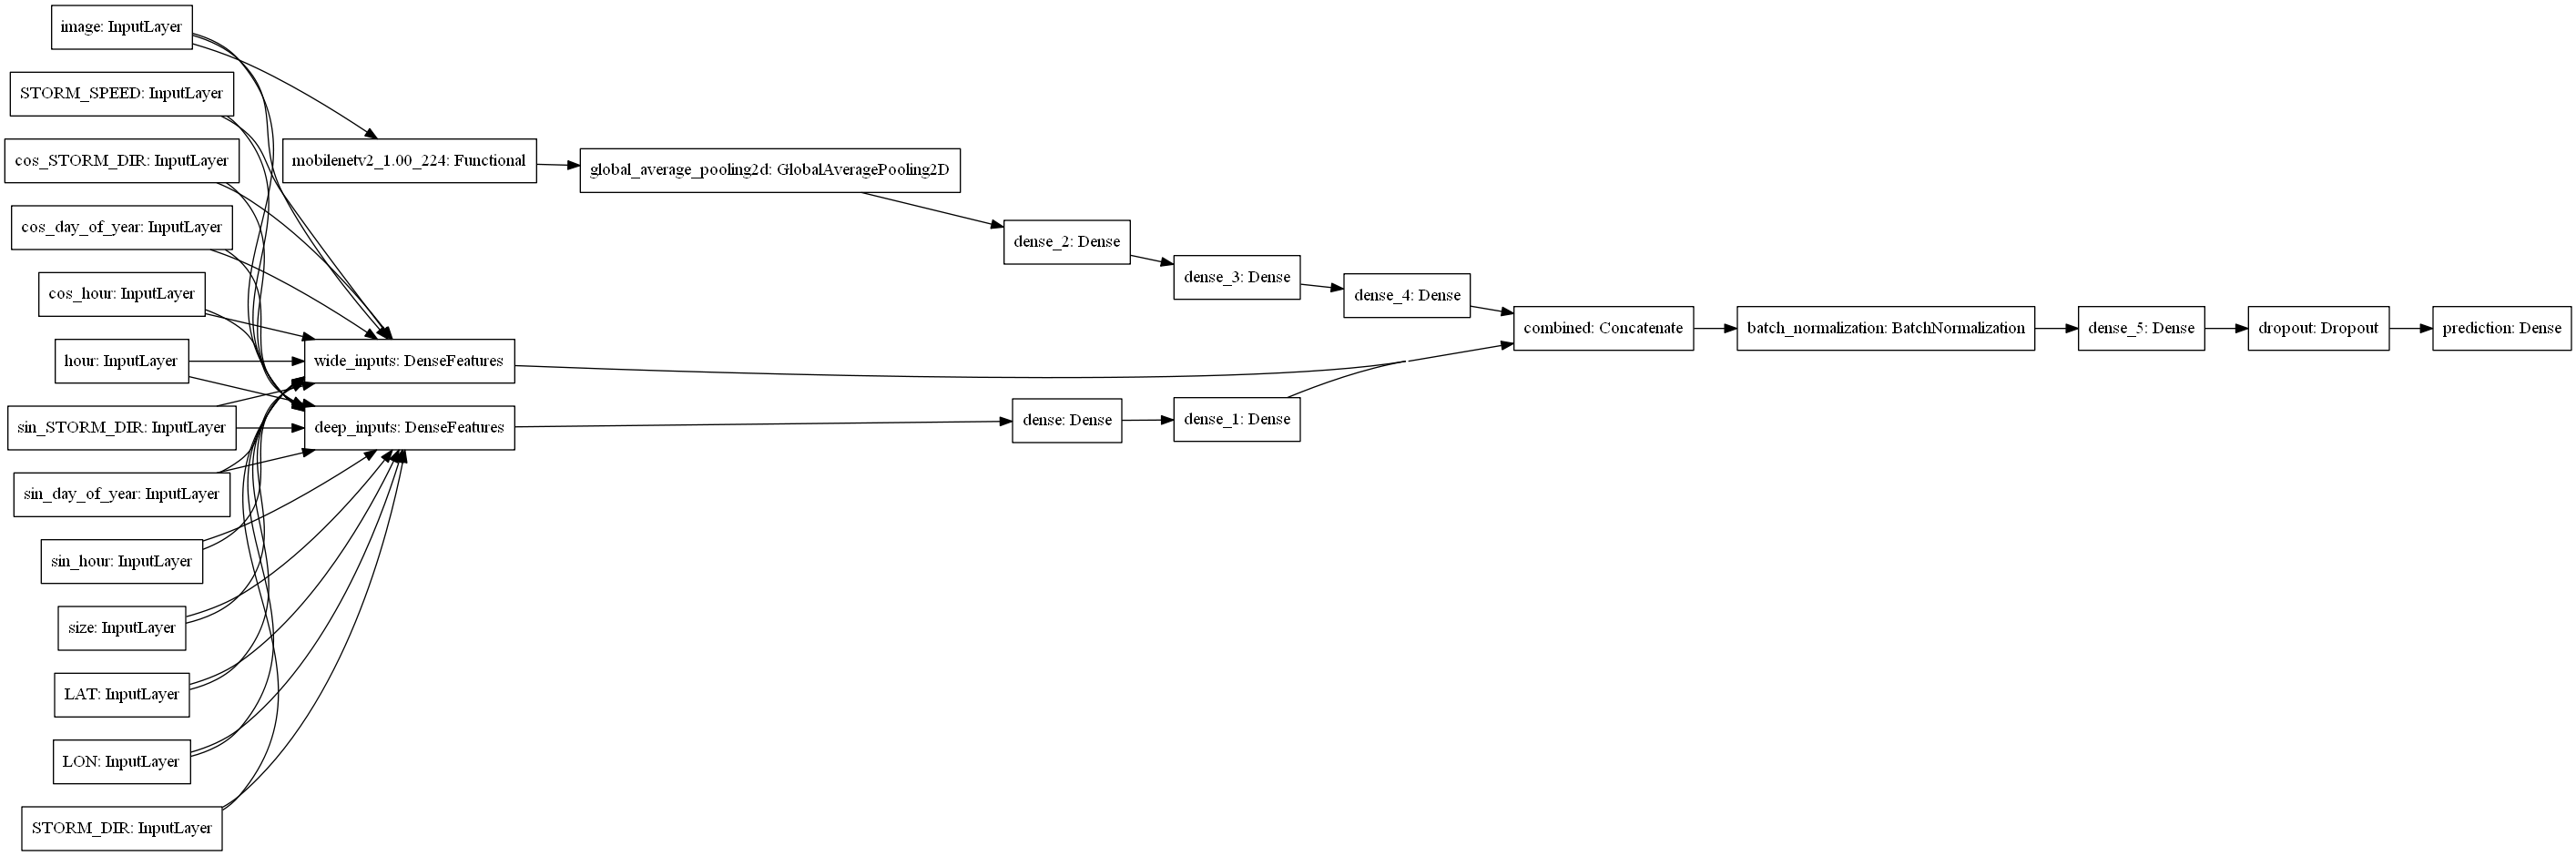

In [21]:
tf.keras.utils.plot_model(model, 'mobilenet_model.png', show_shapes=False, rankdir='LR')


# Callbacks

In [22]:
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=, cooldown=0, 
                                   verbose=1, mode='auto', min_delta=1e-8, min_lr=1e-8)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5)

callback_list=[reduceLROnPlat,early]

Note: changed reduceLROnPlateau to use val_loss as indicator and limited min LR based on previous run. Training loss fluctuated a lot due to the dropout layers.

# Train Model

In [23]:
if __name__ ==  '__main__': #need this for the reduceLRonPlat to work correctly
    history = model.fit(train_ds,validation_data=val_ds,batch_size=batch_size,epochs=100,callbacks=callback_list)

Epoch 1/100
146/146 [==============================] - 59s 315ms/step - loss: 1242.3790 - val_loss: 563.1517
Epoch 2/100
146/146 [==============================] - 43s 294ms/step - loss: 386.9334 - val_loss: 277.6140
Epoch 3/100
146/146 [==============================] - 43s 293ms/step - loss: 272.7970 - val_loss: 440.8833
Epoch 4/100
146/146 [==============================] - 43s 293ms/step - loss: 255.6891 - val_loss: 305.0499

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/100
146/146 [==============================] - 43s 293ms/step - loss: 220.0852 - val_loss: 267.9216
Epoch 6/100
146/146 [==============================] - 43s 297ms/step - loss: 206.1510 - val_loss: 293.6212
Epoch 7/100
146/146 [==============================] - 43s 297ms/step - loss: 213.7477 - val_loss: 276.8026

Epoch 00007: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 8/100
146/146 [==============================] - 44s 298ms/step - loss: 1

In [24]:
history_df=pd.DataFrame(history.history)

In [25]:
history_df.head()

,loss,val_loss,lr
0,762.378662,563.151733,0.0010
1,359.917908,277.614014,0.0010
2,284.641357,440.883301,0.0010
3,251.738602,305.049866,0.0010
4,211.722885,267.921600,0.0001


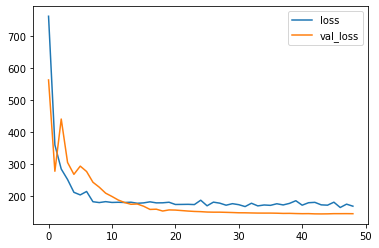

In [26]:
history_df[['loss','val_loss']].plot()

Notes: a curve like this, where validation loss is lower than training loss during the whole training period, can be attributed to a couple things. First, the model contains a Dropout layer, which filters out 50% of the contributing neural network pathways during training, but not during the validation run. Also, the validation set is rather small, so it could just be that handful of storms was represented better than the general population but the model here. 

Another thing to note is that the training loss had almost caught up to the validation loss at the end here. Likely, the learning rate should have started a bit higher (though for whatever reason, the ReduceLROnPlateau callback does not appear to be functioning correctly in this notebook, so I was hesitant to try that initially. But there's certainly a decent chance that had training continued longer here, past the point where training loss was lower than our validation loss, that we could have seen validation loss come down some more.

Either way, this model is outperforming the simple model from the first version of this notebook, though there's certainly still room for improvement.

In [27]:
model.save('hurricane_model_mobilenet.h5')

# Evaluate Model
The curve above shows this model starts overfitting pretty quickly. We do use the model when it had the lower validation error thanks to our use of callbacks here, but the overfitting indicates this model could benefit from more training data. The use of reanalysis data may get us what we need. We could also try some data augmentation, especially with the image data, as well as add dropout layers, and incorporate some regularization.

Validition error is useful at an intellectual level, but what does it really mean? Let's plot a couple sample tracks and compare with what really happened to see how well this performs.

In [28]:
predictions=model.predict(test_ds)

In [29]:
# pred_cols=["pred_"+x for x in ['delta_lat_m3', 'delta_lon_m3', 'delta_lat_m6', 'delta_lon_m6',
#        'delta_lat_m9', 'delta_lon_m9', 'delta_lat_m12', 'delta_lon_m12']]
pred_cols=["pred_lat","pred_lon"]

predictions_df=pd.DataFrame(predictions,columns=pred_cols,index=test_df.index)
predictions_df.head()

,pred_lat,pred_lon
0,-1.595757,2.057816
1,-1.270833,1.639402
41,3.710071,-2.521684
42,4.227469,-2.978462
43,3.262653,-2.525272


In [30]:
predictions_df=predictions_df.merge(test_df,left_index=True,right_index=True)
predictions_df.head()

,pred_lat,pred_lon,SID,ISO_TIME,LAT,LON,STORM_SPEED,STORM_DIR,sin_STORM_DIR,cos_STORM_DIR,...,day_of_year,sin_day_of_year,cos_day_of_year,hour,sin_hour,cos_hour,delta_lat_48hrs,delta_lon_48hrs,filename,size
0,-1.595757,2.057816,2017106N36310,2017-04-16 06:00:00,35.799999,-50.299999,10.0,-119.0,-0.875000,-0.484131,...,106.0,0.966666,-0.256039,6.0,0.997669,-0.068242,-3.900000,5.899998,centered_2017106N36310_20171066.png,62104.0
1,-1.270833,1.639402,2017106N36310,2017-04-16 09:00:00,35.450298,-49.896702,10.0,-119.0,-0.875000,-0.484131,...,106.0,0.966666,-0.256039,9.0,0.631088,-0.775711,-3.677898,5.624001,centered_2017106N36310_20171069.png,60896.0
41,3.710071,-2.521684,2017130N09269,2017-05-09 18:00:00,9.300000,-91.199997,6.0,35.0,0.573730,0.819336,...,129.0,0.792477,-0.609902,18.0,-0.979084,0.203456,2.300000,-2.600006,centered_2017130N09269_201712918.png,93380.0
42,4.227469,-2.978462,2017130N09269,2017-05-09 21:00:00,9.400060,-91.470001,5.0,36.0,0.587891,0.809082,...,129.0,0.792477,-0.609902,21.0,-0.519584,0.854419,2.534941,-2.692497,centered_2017130N09269_201712921.png,93855.0
43,3.262653,-2.525272,2017130N09269,2017-05-10 00:00:00,9.500000,-91.699997,4.0,41.0,0.656250,0.754395,...,130.0,0.781832,-0.623490,0.0,0.000000,1.000000,2.800000,-2.900002,centered_2017130N09269_20171300.png,92336.0


In [31]:
predictions_df.to_pickle('mobilenet_predictions.pkl')

if resuming from a previous run, load previous predictions...

In [32]:
predictions_df=pd.read_pickle('mobilenet_predictions.pkl')

In [33]:
SID='2020254N11343' #random pick from original notebook
sample_storm=predictions_df[predictions_df['SID']==SID].copy()
lllon=sample_storm['LON'].min()-10
urlon=sample_storm['LON'].max()+10
center=(lllon+urlon)/2
lllat=sample_storm['LAT'].min()-10
urlat=sample_storm['LAT'].max()+10
sample_storm.head(5)

,pred_lat,pred_lon,SID,ISO_TIME,LAT,LON,STORM_SPEED,STORM_DIR,sin_STORM_DIR,cos_STORM_DIR,...,day_of_year,sin_day_of_year,cos_day_of_year,hour,sin_hour,cos_hour,delta_lat_48hrs,delta_lon_48hrs,filename,size
7844,8.530541,-4.909606,2020254N11343,2020-09-11 12:00:00,11.0000,-25.000000,30.0,20.0,0.342041,0.939453,...,255.0,-0.952118,-0.305732,12.0,-0.136167,-0.990686,1.133300,-11.000000,centered_2020254N11343_202025512.png,62016.0
7845,8.259656,-4.870460,2020254N11343,2020-09-11 15:00:00,11.1632,-26.224899,23.0,22.0,0.374756,0.927246,...,255.0,-0.952118,-0.305732,15.0,-0.816970,-0.576680,1.157599,-10.314201,centered_2020254N11343_202025515.png,64871.0
7846,7.731547,-4.581165,2020254N11343,2020-09-11 18:00:00,11.3000,-27.299999,24.0,19.0,0.325439,0.945312,...,255.0,-0.952118,-0.305732,18.0,-0.979084,0.203456,1.233300,-9.833302,centered_2020254N11343_202025518.png,67765.0
7847,9.991413,-5.974985,2020254N11343,2020-09-11 21:00:00,11.3730,-28.617500,25.0,16.0,0.275635,0.961426,...,255.0,-0.952118,-0.305732,21.0,-0.519584,0.854419,1.331700,-9.114300,centered_2020254N11343_202025521.png,68238.0
7848,8.145687,-5.019872,2020254N11343,2020-09-12 00:00:00,11.4000,-29.799999,19.0,15.0,0.258789,0.965820,...,256.0,-0.957253,-0.289252,0.0,0.000000,1.000000,1.466701,-8.600002,centered_2020254N11343_20202560.png,70827.0


To compare Apples to Apples, we need to plot our forecasts from a given point at each of the timesteps out (which will all be on one row) against actual future points (which will be on the following rows). So, we need to narrow our window for our storm track to 12 hours. Every 3 hours, we get a new projected trajectory. This might be tricky. Simplest solution is to build a function that will return what we want.

In [34]:
def get_forecast_coords(row):
#     DT=row['ISO_TIME'].sample(1).values[0]

#     forecasts=predictions_df[(predictions_df['SID']==SID) & (predictions_df['ISO_TIME']==DT)]
    LATs=[row['LAT'],row['LAT']+row['pred_lat']]
    LONs=[row['LON'],row['LON']+row['pred_lon']]
    return LONs,LATs


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


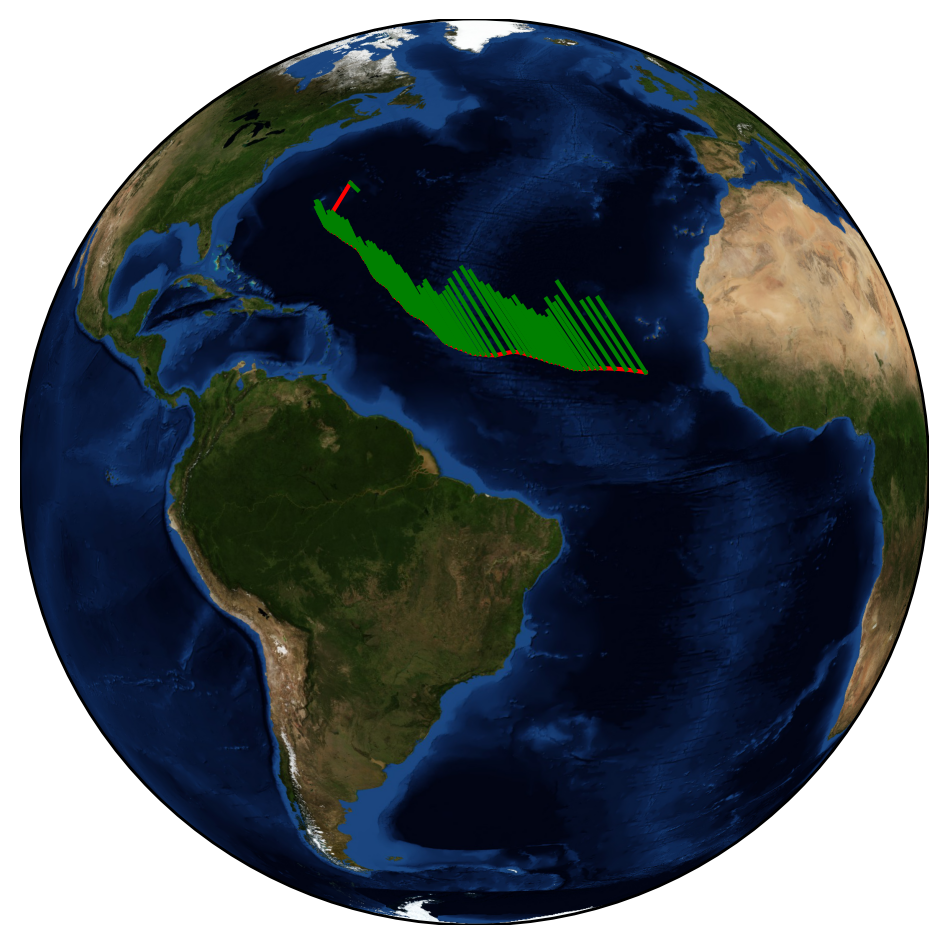

In [35]:
fig = plt.figure(figsize=(6,6),dpi=200)
m = Basemap(projection='geos', lon_0=center,lat_0=0,rsphere=(6378137.00,6356752.3142))
#             llcrnrx=X.min(), llcrnry=Y.min(), urcrnrx=X.max(), urcrnry=Y.max())
m.bluemarble(zorder=0)
m.plot(sample_storm['LON'].values,sample_storm['LAT'].values,latlon=True,color='r',zorder=10)
for i,row in sample_storm.iterrows():
    LONs,LATs=get_forecast_coords(row)
    m.plot(LONs,LATs,latlon=True,color='g',zorder=10)

# xmin, ymin = m(lllon, lllat)
# xmax, ymax = m(urlon, urlat)

# ax = plt.gca()

# ax.set_xlim([xmin, xmax])
# ax.set_ylim([ymin, ymax])


plt.show()

# Design Improvements / Next Steps
1. Explore using the new Tensorflow3D platform to model hurricanes using realtime 3d model data, like what's provided in the reanalysis data, and realtime forecast models.
1. Explore different CNN architectures. MobileNet is one of many.
1. Explore using full disk images both instead of and an addition to the centered views.
1. Bring in GOES17 data and test using it in two ways:
    1. To broaden the area where we can pull historic data from
    2. To narrow the area, but give us two views (stereoscopic) of each storm snapshot.
1. Test capsule networks both with the centered storm views and full disk views. Capsule networks are supposed to capture more information regarding where in an image a specific feature is located, which should make them more suited to this task than a network architecture design for type classification, which would be preferable if we were trting to look at images of storms and classify their severity, for instance.
1. Test using surface temperate and ground temperature data, which is available from GOES16 and 17, but for a much smaller timeframe. Augment with historic reanlysis data.
1. Test different output types. Make this into a classification problem where we identify which future gridpoint the storm will be located in, instead of its exact center.